In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import math
import statistics
import warnings
import numpy as  np
import ast
import re
from scipy.signal import resample
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
warnings.filterwarnings('ignore')

df = pd.read_json(r"C:\Users\veoni\Documents\GitHub\MTE_DLAB\Squircle experiment\DF_clean.json")
df = df[(df['block_number'] != 'Training')]
df_acc = df[(df['difficulty'] != 'Control') & (df['acc'] != 'Control') & (df['acc'] != 'NAN')]

# Convert 'acc' column to 1 for True and 0 for False
df_acc['acc'] = df_acc['acc'].astype(int)
df = df.drop('Unnamed: 0', axis=1, errors='ignore')
#shortened df
df_comp = df[['pt_num','trial_nbr','block_number', 'acc', 'choice', 'true_value', 'difficulty', 'rt', 'previous_response', 'downsampled_traj', 'timestamps']].copy()

In [2]:
# Calculate average accuracy and reaction time by difficulty level
avg_stats = df_acc.groupby(['difficulty', 'true_value'] ).agg({'acc': 'mean', 'rt': 'mean'}).reset_index()
print(avg_stats)

  difficulty true_value       acc        rt
0       Easy       Blue  0.864674  0.460808
1       Easy        Red  0.841806  0.467413
2       Hard       Blue  0.715600  0.480877
3       Hard        Red  0.667774  0.493310
4     Medium       Blue  0.785950  0.471630
5     Medium        Red  0.752135  0.478263


### Preprocessing

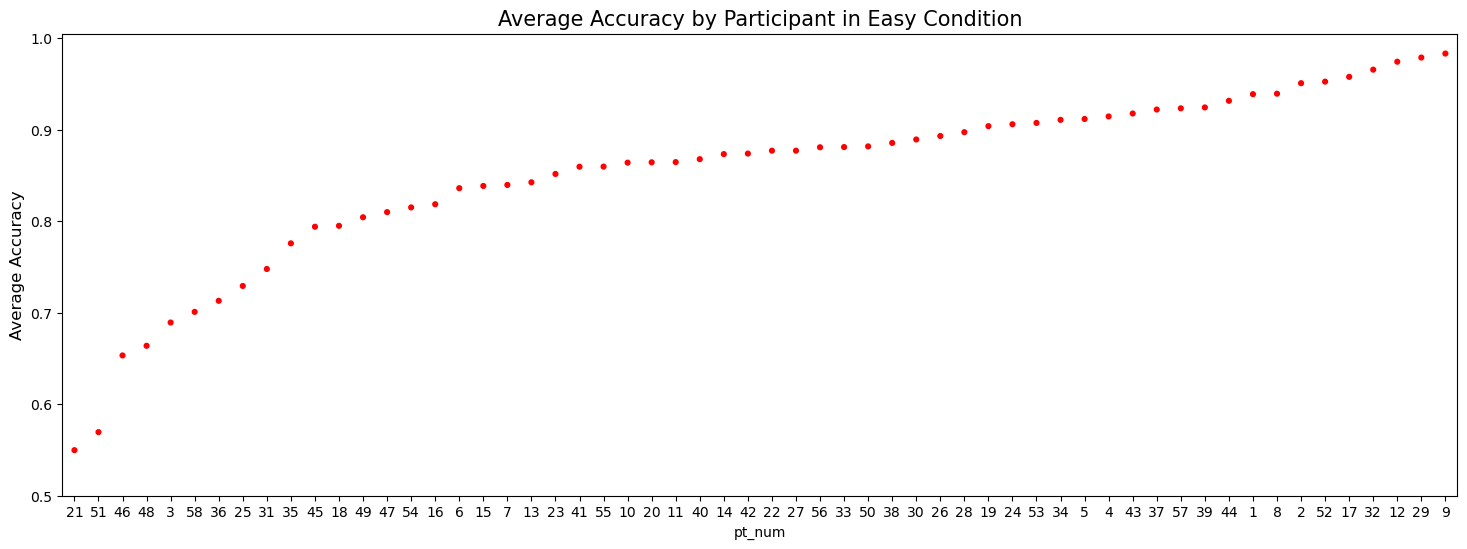

In [3]:
# Calculate the average accuracy per participant and plotting the results
avg_stats_pt = df_acc.groupby(['pt_num', 'difficulty']).agg({'acc': 'mean'}).reset_index()
avg_stats_pt_easy = avg_stats_pt[avg_stats_pt['difficulty'] == 'Easy']
avg_stats_pt_easy_sorted = avg_stats_pt_easy.sort_values('acc', ascending=True)

# Plotting the results
# Add pt_num numbers next to the points

# Plotting the results
plt.figure(figsize=(18, 6))  # Increase the size of the figure

ax = sns.pointplot(data=avg_stats_pt_easy_sorted, x='pt_num', y='acc', color='red', order=avg_stats_pt_easy_sorted['pt_num'], join=False, scale=0.5)
ax.set_title('Average Accuracy by Participant in Easy Condition', fontsize=15)  # Add the title
# Adjust the font size of y-axis labels
ax.set_ylabel('Average Accuracy', fontsize=12)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])  # Set the y-axis range



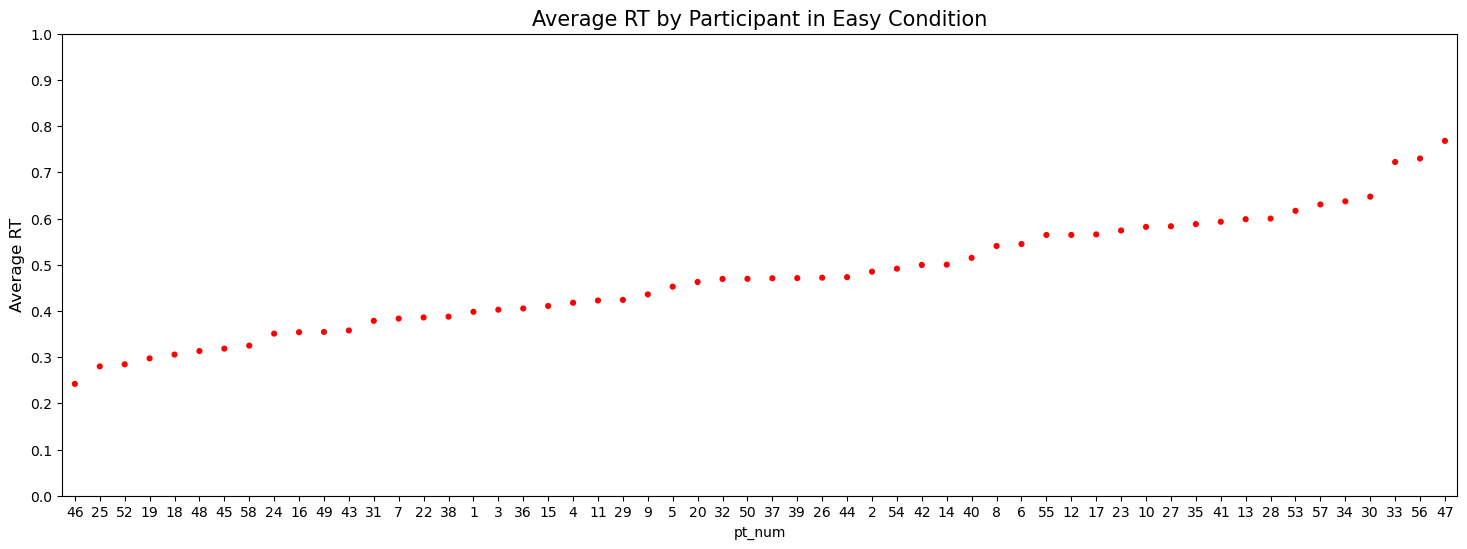

In [3]:
#Removing partcipants 21 and 51
# Doing the same procedure for RT.
df_filtered = df_comp[(df_comp['pt_num'] != 21) & (df_comp['pt_num'] != 51)]

avg_stats_rt = df_filtered.groupby(['pt_num', 'difficulty']).agg({'rt': 'mean'}).reset_index()
avg_stats_rt_easy = avg_stats_rt[avg_stats_rt['difficulty'] == 'Easy']
avg_stats_rt_easy_sorted = avg_stats_rt_easy.sort_values('rt', ascending=True)
plt.figure(figsize=(18, 6))  # Increase the size of the figure

ax = sns.pointplot(data=avg_stats_rt_easy_sorted, x='pt_num', y='rt', color='red', order=avg_stats_rt_easy_sorted['pt_num'], join=False, scale=0.5)
ax.set_title('Average RT by Participant in Easy Condition', fontsize=15)  # Add the title
# Adjust the font size of y-axis labels
ax.set_ylabel('Average RT', fontsize=12)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])  # Set the y-axis range

0.101161609


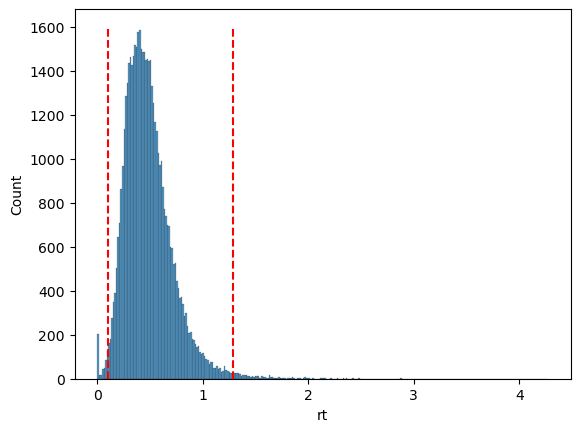

In [5]:
#Participant based Rts does not show striking differences between participants.
# We do quantile based rejection to cope with the outliers.
# Quantile based plotting
q1 = df_filtered['rt'].quantile(0.99)
q2 = df_filtered['rt'].quantile(0.01)
print(q2)
sns.histplot(data=df_filtered, x='rt')
plt.vlines(q1, 0, 1600, color='red', linestyle='--')
plt.vlines(q2, 0, 1600, color='red', linestyle='--')

<Axes: xlabel='rt', ylabel='Count'>

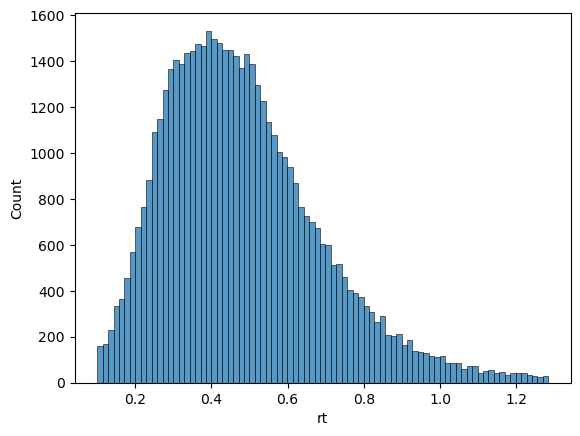

In [6]:
# Filtering the data q1 around 100ms and q2 around 2sec
df_filtered = df_filtered[(df_filtered['rt'] >= q2) & (df_filtered['rt'] <= q1)]
# Next we plot the data again to see if the outliers are removed
sns.histplot(data=df_filtered, x='rt')


### Manual Preprocessing


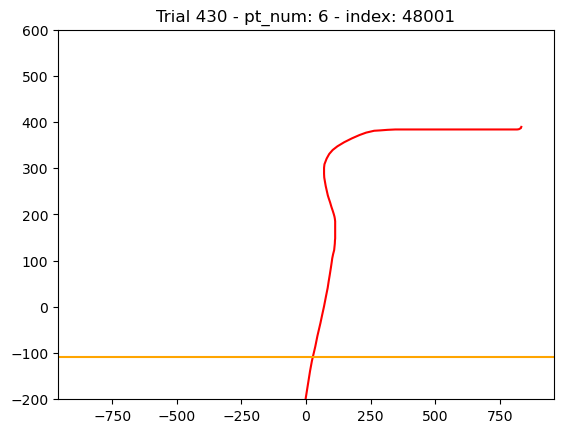

In [4]:
df_manrev = pd.read_json(r"C:\Users\veoni\Documents\GitHub\MTE_DLAB\Analysis\DF_manrev.json")
#df_manrev = pd.DataFrame(columns=['pt_num', 'trial_nbr', 'block_number', 'acc', 'choice', 'true_value', 'difficulty', 'rt', 'previous_response', 'downsampled_traj', 'timestamps'])
class TrialViewer:
    def __init__(self, df_filtered):
        self.df_filtered = df_filtered
        self.current_index = 48001

        self.root = tk.Tk()
        self.root.title("Trial Viewer")

        self.label = tk.Label(self.root, text="Trial: 0")
        self.label.pack()

        self.figure, self.ax = plt.subplots()
        self.canvas = FigureCanvasTkAgg(self.figure, master=self.root)
        self.canvas.get_tk_widget().pack()

        self.reject_button = tk.Button(self.root, text="Reject (F)", command=self.reject_trial)
        self.reject_button.pack(side=tk.LEFT)
        self.reject_button.bind("<F>", self.reject_trial)  # Bind 'F' key

        self.accept_button = tk.Button(self.root, text="Accept (J)", command=self.accept_trial)
        self.accept_button.pack(side=tk.LEFT)
        self.accept_button.bind("<J>", self.accept_trial)  # Bind 'J' key

        self.previous_button = tk.Button(self.root, text="Previous", command=self.previous_trial)
        self.previous_button.pack(side=tk.LEFT)

        self.next_button = tk.Button(self.root, text="Next", command=self.next_trial)
        self.next_button.pack(side=tk.LEFT)

        self.show_current_trial()
        
        # Set focus on the root window to capture keyboard events
        self.root.focus_set()

        # Bind keyboard shortcuts
        self.root.bind("<Key>", self.key_pressed)

        self.root.mainloop()

    def show_current_trial(self):
        trial_data = self.df_filtered.iloc[self.current_index]['downsampled_traj']
        pt_num = self.df_filtered.iloc[self.current_index]['pt_num']  # Get pt_num
        choice = self.df_filtered.iloc[self.current_index]['choice']  
        trial_nbr = self.df_filtered.iloc[self.current_index]['trial_nbr']
        self.ax.clear()
        x_coords = [pos[0] for pos in trial_data]
        y_coords = [pos[1] for pos in trial_data]
        if choice == 'Red':
            self.ax.plot(x_coords, y_coords, color='red')  # Plot each segment in red
        elif choice == 'Blue':
            self.ax.plot(x_coords, y_coords, color='blue')  # Plot each segment in blue
        self.ax.set_xlim(-960, 960)
        self.ax.set_ylim(-200, 600)
        self.ax.hlines(-108, -960, 960, color='orange')  # Add a vertical line at the center
        self.ax.set_title("Trial {} - pt_num: {} - index: {}".format(trial_nbr, pt_num, self.current_index))  # Update title
        self.canvas.draw_idle()
        self.label.config(text="Trial: {}".format(self.current_index))

    def reject_trial(self, event=None):
        # Implement what happens when the trial is rejected
        print("Index {} rejected.".format(self.current_index))
        self.next_trial()

    def accept_trial(self, event=None):
        # Implement what happens when the trial is accepted
        print("Index {} accepted.".format(self.current_index))
        # Add accepted trial to your new dataframe (e.g., df_manrev)
        accepted_trial = self.df_filtered.iloc[self.current_index]
        # Do something with accepted_trial, e.g., 
        global df_manrev
        df_manrev = df_manrev._append(accepted_trial, ignore_index=True)

        # Show the next trial
        self.next_trial()

    def previous_trial(self):
        if self.current_index > 0:
            self.current_index -= 1
            self.show_current_trial()
            df_manrev = df_manrev.drop(df_manrev.index[-1])

    def next_trial(self):
        if self.current_index < len(self.df_filtered) - 1:
            self.current_index += 1
            self.show_current_trial()
    def key_pressed(self, event):
            if event.char.lower() == 'f':
                self.reject_trial()
            elif event.char.lower() == 'j':
                self.accept_trial()
# Example usage:
# Assuming df_filtered is your filtered DataFrame
# You need to have matplotlib installed for plotting
app = TrialViewer(df_filtered)
#print(TrialViewer.self.current_index)
#df_manrev.to_json(r"C:\Users\veoni\Documents\GitHub\MTE_DLAB\Analysis\DF_manrev.json")

In [17]:
drop_list = [500, 792, 987, 8109, 9204, 9704, 10460, 11225, 11254, 11808, 12171, 141611, 14935,14936, 15470, 15907, 18456, 18499, 19501, 19657, 19869, 20339, 21963, 22423, 22762, 22895, 23870, 23886, 24012, 24056, 24417, 24725, 24898, 25756, 26478, 26634, 27029, 27630, 27726, 27754, 27889, 28133, 28166, 28290, 28752, 28922, 29195, 29733, 31190, 33168, 33545, 34276, 34517, 34886, 35121, 35167, 35174, 35550, 35764, 36950, 37236, 37393, 38552, 39427, 39491, 39598, 40498, 41304, 41371, 41858, 41983, 42035, 42232, 42456, 42823, 43226, 43541, 43801, 44006, 44190, 44439, 44440, 44581, 44796, 44814, 45452, 46842, 47021, 47032, 47624, 47716, 47791, 47919, 48087, 48114, 48455, 48896, 49011, 49045, 49171, 49458, 50214]

In [44]:
drop_list = [500, 792, 987, 8109, 9204, 9704, 10460, 11225, 11254, 11808, 12171, 14611, 14935,14936, 15470, 15907, 18456, 18499, 19501, 19657, 19869, 20339, 21963, 22423, 22762, 22895, 23870, 23881, 24056, 24417, 24725, 24898, 25756, 26634, 27029, 27630, 27726, 27754, 27889, 28133, 28166, 28290, 28752, 28922, 29195, 29733, 31190, 33168, 33545, 34276, 34517, 34886, 35121, 35167, 35174, 35550, 35764, 36950, 37236, 37393, 38552, 39427, 39491, 39598, 40498, 41304, 41371, 41858, 41983, 42035, 42232, 42456, 42823, 43226, 43541, 43801, 44006, 44190, 44439, 44440, 44581, 44796, 44814, 45452, 46842, 47021, 47032, 47624, 47716, 47791, 47919, 48087, 48114, 48455, 48896, 49011, 49045, 49171, 49458, 50214]
drop_info = []
for i in drop_list:
    drop_info.append((df_filtered['pt_num'].iloc[i], df_filtered['trial_nbr'].iloc[i]))
    


In [46]:
# Drop rows from df_manrev based on pt_num and trial_nbr
drop_info = [(pt_num, trial_nbr) for pt_num, trial_nbr in drop_info]
df_manrev = df_manrev[~df_manrev[['pt_num', 'trial_nbr']].apply(tuple, axis=1).isin(drop_info)]

df_manrev.to_json(r"C:\Users\veoni\Documents\GitHub\MTE_DLAB\Analysis\DF_manrev.json")

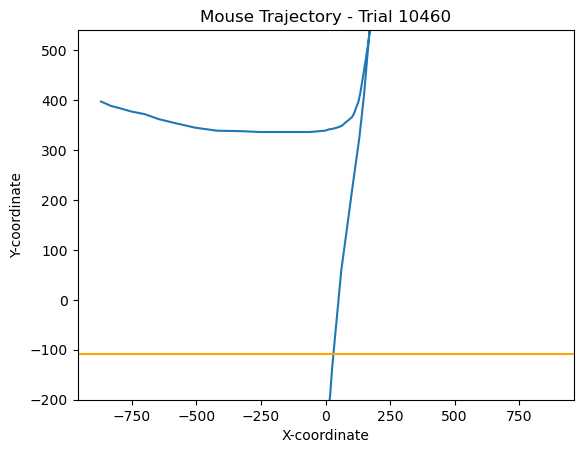

In [43]:
import matplotlib.pyplot as plt

# Get the mouse trajectory data for trial 10460
trajectory = df_filtered['downsampled_traj'].iloc[26634]

# Extract x and y coordinates from the trajectory data
x_coords = [pos[0] for pos in trajectory]
y_coords = [pos[1] for pos in trajectory]

# Plot the mouse trajectory
plt.plot(x_coords, y_coords)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.xlim(-960, 960)
plt.ylim(-200, 540)
plt.hlines(-108, -960, 960, color='orange')  # Add a vertical line at the center
plt.title('Mouse Trajectory - Trial 10460')
plt.show()


In [7]:
mean_data_points = df_filtered['downsampled_traj'].apply(lambda x: len(x)).mean()
print(mean_data_points)

df_filtered['new_timestamps'] = df_filtered['timestamps']

df_filtered['new_timestamps'] = df_filtered['downsampled_traj'].apply(lambda x: [i * 0.01 for i in range(len(x))])



118.13885575699746


In [8]:
avg_timestamps = df_filtered['new_timestamps'].apply(lambda x: np.mean(x)).mean()
df_filtered['new_timestamps'][0][59]

def cut_and_fill_traj(traj, length=60, before=10):
    start_index = None
    for i, (x, y) in enumerate(traj):
        if y >= -108:
            start_index = i
            break
    
    if start_index is None:
        return traj[:length]
    beg_index = start_index - before
    end_index = start_index + length
    traj = traj[beg_index:end_index]
    
    if len(traj) < length:
        traj.extend([(float('NAN'), float('NAN'))] * (length - len(traj)))
    
    return traj

tri1 = cut_and_fill_traj(df_filtered['downsampled_traj'][45678], length=80, before=10)
len(tri1)

90

In [9]:
df_filtered['match_traj'] = df_filtered['downsampled_traj'].apply(cut_and_fill_traj)


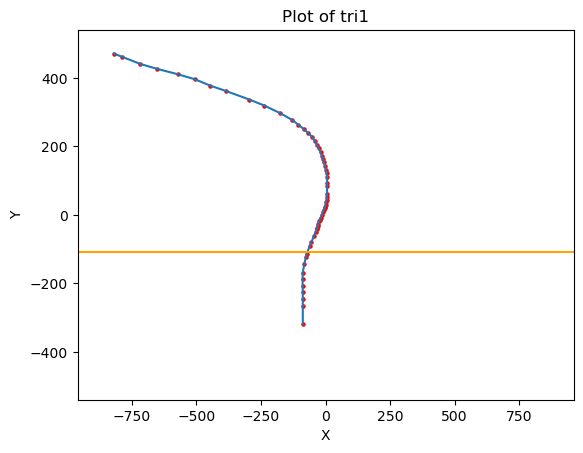

In [10]:
import matplotlib.pyplot as plt

x_coords = [pos[0] for pos in df_filtered['match_traj'][4568]]
y_coords = [pos[1] for pos in df_filtered['match_traj'][4568]]

plt.scatter(x_coords, y_coords, color='red', s=5)
plt.plot(x_coords, y_coords)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-960, 960)
plt.ylim(-540, 540)
plt.hlines(-108, -960, 960, color='orange')
plt.title('Plot of tri1')
plt.show()


In [10]:
def cut_off_trajectory(traj):
    return [pos for pos in traj if pos[1] >= -108]

df_filtered['cut_traj'] = df_filtered['downsampled_traj'].apply(cut_off_trajectory)


TypeError: complex() first argument must be a string or a number, not 'list'

In [ ]:
""" ### SCRAPPED!!!!

# Get unique participant numbers from the DataFrame and sort them
participant_numbers = sorted(df_filtered['pt_num'].unique())

# Loop through each participant
for participant_num in participant_numbers:
    # Create a new figure for each participant
    plt.figure(figsize=(12, 6))

    subset_data_list = []
    conditions = [('Easy', 'Blue'),
                  ('Medium', 'Blue'),
                  ('Hard', 'Blue'),
                  ('Control', 'Control'),
                  ('Hard', 'Red'),
                  ('Medium', 'Red'),
                  ('Easy', 'Red')]

    for j, (difficulty, true_color) in enumerate(conditions, 1):
        subset_data = df_filtered[(df_filtered['difficulty'] == difficulty) & (df_filtered['true_value'] == true_color) & (df_filtered['pt_num'] == participant_num)]
        probabilities = subset_data['choice'].value_counts(normalize=True).get('Red', 0)

        subset_data_list.append({'Condition': f'{difficulty} {true_color}', 'Probability of Red': probabilities})

    # Create a DataFrame from the list
    plot_data = pd.DataFrame(subset_data_list)

    # Plotting using sns.pointplot
    sns.pointplot(x='Condition', y='Probability of Red', data=plot_data, order=[f'{c[0]} {c[1]}' for c in conditions])

    # Set the title and labels
    plt.title(f'Psychometric Functions - Participant {participant_num}')
    plt.xlabel('Condition')
    plt.ylabel('Probability of Red')
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
    

    # Show the plot
    plt.savefig(f'Participant_{participant_num}_psychometric_function.png')
 """

In [ ]:
# Optional: Pruning the trajectories if out of bounds
# This function takes a DataFrame and returns a list of pruned trajectories (i.e., trajectories that are within the specified x and y cutoffs)
def prune_trajectories(df, x_cutoff=390, y_cutoff=810):
    pruned_trajectories = []

    for traj in df['downsampled_traj']:
        pruned_traj = [(x, y) for x, y in traj if abs(x) <= x_cutoff and y <= y_cutoff]
        pruned_trajectories.append(pruned_traj)

    return pruned_trajectories

# Assuming df_comp is your DataFrame
pruned_trajectories = prune_trajectories(df_comp)

df_bnd = prune_trajectories(df_filtered)

TypeError: 'int' object is not iterable

In [8]:
org_len= 50304
# Optional: filter the trajectories
# Filtering out the trajectories that are not increasing in terms of y axis
def cut_off_trajectory(traj):
    return [pos for pos in traj if pos[1] >= -108]

df_filtered['cut_traj'] = df_filtered['downsampled_traj'].apply(cut_off_trajectory)


shifted_value = y_values.shift() #should be previous
value = y_values

sum(all(shifted_value < value) 

sum(1,2,3)

    
def filter_trajectories(df, tolerance=20):
    filtered_rows = []

    for index, row in df.iterrows():
        y_values = [point[1] for point in row['cut_traj']]
        is_increasing = all(y_values[i] <= y_values[i + 1] + tolerance for i in range(len(y_values) - 1))
        
        if is_increasing:
            filtered_rows.append(row)

    filtered_df = pd.DataFrame(filtered_rows)
    return filtered_df
# Assuming df_comp is your DataFrame
#df_filtered = filter_trajectories(df_filtered, tolerance=20)

total_trials = len(df_filtered)
tol_vals = []
for i in range(1, 100):
    df_filtered1 = filter_trajectories(df_filtered, tolerance=i)
    excluded_trials = 50304 - len(df_filtered1)
    proportion_excluded = excluded_trials / 50304  # Calculate proportion
    tol_vals.append((i, proportion_excluded))

plt.bar([i[0] for i in tol_vals], [i[1] for i in tol_vals])
plt.xlabel('Tolerated pixel decrease')
plt.ylabel('Proportion of Excluded Trials')
plt.show()

SyntaxError: '(' was never closed (189209360.py, line 13)

### Big plot

In [ ]:
# Set the style of seaborn
sns.axes_style()
# Define a color-blind friendly palette with distinct patterns for Easy, Medium, Hard, and Control
palette = sns.color_palette("colorblind", 4)

# Specify the order of difficulty conditions excluding 'Control'
difficulty_order_acc = ['Easy', 'Medium', 'Hard']

# Conditions for the new plot
conditions = [('Easy', 'Blue'),
              ('Medium', 'Blue'),
              ('Hard', 'Blue'),
              ('Control', 'Control'),
              ('Hard', 'Red'),
              ('Medium', 'Red'),
              ('Easy', 'Red')]

# Get unique participant numbers from the DataFrame and sort them
participant_numbers = sorted(df_comp['pt_num'].unique())

# Loop through each participant
for i, participant_num in enumerate(participant_numbers):
    sns.axes_style()
    # Filter the DataFrame for the current participant
    participant_data = df_comp[df_comp['pt_num'] == participant_num]

    # Calculate the average accuracy and 'Red' choice ratio per block for the current participant
    avg_accuracy_per_block = (participant_data[participant_data['difficulty'] != 'Control']
                              .groupby(['block_number', 'difficulty'])['acc']
                              .mean()
                              .reset_index())

    red_choice_ratio_per_block = (participant_data[participant_data['choice'] == 'Red']
                                  .groupby(['block_number', 'difficulty'])['choice']
                                  .count() / participant_data.groupby(['block_number', 'difficulty'])['choice'].count()).reset_index()

    # Extract and sort the numeric part of block numbers
    avg_accuracy_per_block['block_number'] = avg_accuracy_per_block['block_number'].apply(lambda x: int(re.search(r'\d+', x).group()))
    red_choice_ratio_per_block['block_number'] = red_choice_ratio_per_block['block_number'].apply(lambda x: int(re.search(r'\d+', x).group()))

    # Sort the DataFrame by block number and difficulty
    avg_accuracy_per_block = avg_accuracy_per_block.sort_values(by=['block_number', 'difficulty'])
    red_choice_ratio_per_block = red_choice_ratio_per_block.sort_values(by=['block_number', 'difficulty'])

    # Plot 0: Average Accuracy per Block
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(24, 16))

    sns.pointplot(x="block_number", y="acc", hue="difficulty", data=avg_accuracy_per_block, palette=palette, markers="o", linestyles="-", ax=axs[0, 0], join=True)
    overall_avg_accuracy = (participant_data[participant_data['difficulty'] != 'Control'].groupby('block_number')['acc'].mean().reset_index())
    sns.pointplot(x="block_number", y="acc", data=overall_avg_accuracy, color='black', ax=axs[0, 0], label='Overall Average')
    axs[0, 0].set_xlabel("Block Number")
    axs[0, 0].set_ylabel("Average Accuracy")
    axs[0, 0].set_yticks([0,0.25,0.50,0.75,1.0])
    axs[0, 0].set_ylim(0, 1)  # Assuming accuracy values are between 0 and 1
    axs[0, 0].tick_params(axis='y', labelcolor=palette[0])
    axs[0, 0].set_title(f"Avg Accuracy per Block - Participant {participant_num}")
    axs[0, 0].legend(title='Difficulty', loc='lower left')

    # Plot 1: 'Red' Choice Ratio per Block
    ax2 = axs[0, 1]
    sns.pointplot(x="block_number", y="choice", data=red_choice_ratio_per_block, color='red', ci=None, markers="x", linestyles="--", ax=ax2, join=False)
    ax2.set_ylabel("'Red' Choice Ratio")
    ax2.set_yticks([0,0.25,0.50,0.75,1.0])
    ax2.set_ylim(0, 1)  # Assuming choice ratio values are between 0 and 1
    ax2.tick_params(axis='y', labelcolor=palette[1])

    # Plot 2: Reaction Time by Trial Number
    sns.scatterplot(x="trial_nbr", y="rt", hue="difficulty", data=participant_data, palette=palette, markers="x", linestyles="-", ax=axs[1, 0])
    axs[1, 0].set_xlabel("Trial Number")
    axs[1, 0].set_ylabel("Reaction Time (rt)")
    axs[1, 0].set_ylim(0, 5)
    axs[1, 0].set_title(f"Reaction Time by Trial Number - Participant {participant_num}")

    # Add a legend for the difficulty conditions
    axs[1, 0].legend(title='Difficulty', loc='upper right')

    # Plot 3: Average Accuracy per Difficulty (excluding 'Control')
    sns.pointplot(x="difficulty", y="acc", data=avg_accuracy_per_block, palette=palette[:-1], order = ['Easy', 'Medium', 'Hard'], markers="o", linestyles="-", ax=axs[1, 1], join=True)
    axs[1, 1].set_xlabel("Difficulty")
    axs[1, 1].set_ylabel("Average Accuracy")
    axs[1, 1].set_yticks([0,0.25,0.50,0.75,1.0])
    axs[1, 1].set_ylim(0, 1)  # Assuming accuracy values are between 0 and 1
    axs[1, 1].tick_params(axis='y', labelcolor=palette[0])
    axs[1, 1].set_title(f"Avg Accuracy per Difficulty - Participant {participant_num}")

    
    #sns.set_style("whitegrid", {"grid.color": ".001", "grid.linestyle": ":"})
    # Plot 4: Reaction Time per Difficulty (including 'Control')
    sns.pointplot(x="difficulty", y="rt", data=participant_data, palette=palette, markers="x",order = ['Easy', 'Medium', 'Hard', 'Control'], linestyles="-", ax=axs[2, 0])
    axs[2,0].set_ylabel('RT')
    
    # Plot 5: Probability of Choosing Red for Each Condition
    #sns.set_style("whitegrid", {"grid.color": ".001", "grid.linestyle": ":"})
    ax5 = axs[2, 1]  # Twin Axes for the new plot
    subset_data_list = []

    for j, (difficulty, true_color) in enumerate(conditions, 1):
        subset_data = participant_data[(participant_data['difficulty'] == difficulty) & (participant_data['true_value'] == true_color)]
        probabilities = subset_data['choice'].value_counts(normalize=True).get('Red', 0)

        subset_data_list.append({'Condition': f'{difficulty} {true_color}', 'Probability of Red': probabilities})

    # Create a DataFrame from the list
    plot_data = pd.DataFrame(subset_data_list)

    # Plotting using sns.pointplot
    sns.pointplot(x='Condition', y='Probability of Red', data=plot_data, order=[f'{c[0]} {c[1]}' for c in conditions], ax=ax5)
    ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    ax5.set_title('Probability of Choosing Red for Each Condition')
    ax5.set_xlabel('Condition')
    ax5.set_yticks([0,0.25,0.50,0.75,1.0])
    ax5.set_ylabel('Probability of Choosing Red')
    
    #Plot-6
    #sns.set_style("whitegrid", {"grid.color": ".001", "grid.linestyle": ""})
        # Filter data for each difficulty level
    easy_data = participant_data[participant_data['difficulty'] == 'Easy']
    medium_data = participant_data[participant_data['difficulty'] == 'Medium']
    hard_data = participant_data[participant_data['difficulty'] == 'Hard']
    control_data = participant_data[participant_data['difficulty'] == 'Control']
    
    # Group data by block number and count the number of trials
    easy_counts = easy_data['block_number'].value_counts().sort_index()
    medium_counts = medium_data['block_number'].value_counts().sort_index()
    hard_counts = hard_data['block_number'].value_counts().sort_index()
    control_counts = control_data['block_number'].value_counts().sort_index()
    df_counts = pd.DataFrame({
    'Easy': easy_counts,
    'Medium': medium_counts,
    'Hard': hard_counts,
    'Control': control_counts})
    df_counts_reset = df_counts.reset_index()
    sns.pointplot(data=df_counts_reset.melt(id_vars='block_number', var_name='Difficulty', value_name='Number of Trials'),
              x='block_number', y='Number of Trials', hue='Difficulty',
              palette=['blue', 'green', 'orange', 'gray'], markers='o', linestyles='-',join = False, ax=axs[3,0])
    # Set labels and title
    axs[3,0].set_xlabel("Block Number")
    axs[3,0].set_ylabel("Number of Trials")
    axs[3,0].set_title("Number of Trials per Difficulty Level and Block")
    axs[3,0].set_yticks([0,25,50])
    """"
    # PLOT-7
    participant_data['pruned_traj'] = ""
    for i in range(len(participant_data['mtch_traj'])):
        ms_traj = participant_data['mtch_traj'].iloc[i]
        pruned_traj = [[x, y] for x, y in ms_traj if y >= -108]
        participant_data['pruned_traj'].iloc[i] = pruned_traj
    
    df_blue = participant_data[participant_data['choice'] == 'Blue']
    df_red = participant_data[participant_data['choice'] == 'Red']
    
    # Plot Blue Trajectories
    for z in range(len(df_blue)):
        x_coords = [pos[0] for pos in df_blue['pruned_traj'].iloc[z]]
        y_coords = [pos[1] for pos in df_blue['pruned_traj'].iloc[z]]
    
        sns.lineplot(x=x_coords, y=y_coords, label='Mouse Trajectory', color='blue', alpha=0.2, ax=axs[3, 1])
    
    # Plot Red Trajectories
    for b in range(len(df_red)):
        x_red_coords = [pos[0] for pos in df_red['pruned_traj'].iloc[b]]
        y_red_coords = [pos[1] for pos in df_red['pruned_traj'].iloc[b]]
    
        sns.lineplot(x=x_red_coords, y=y_red_coords, label='Mouse Trajectory', color='red', alpha=0.2,ax=axs[3, 1])
    
    # Add labels and title
    axs[3, 1].set_xlabel('X Position')
    axs[3, 1].set_ylabel('Y Position')
    axs[3, 1].set_title('Mouse Trajectory')
    
    # Set x-axis limits to show the left side of the screen
    axs[3, 1].set_xlim(-960, 960)
    axs[3, 1].set_ylim(-500, 500)  # Assuming max(x_coords) is the rightmost position
    axs[3, 1].hlines(-108, xmin=-800, xmax=800, colors='orange')
    axs[3, 1].legend_ = None
    
    # PLOT-8
    red_trajectories = df_red['pruned_traj'] # List of mouse trajectories for red responses
    blue_trajectories = df_blue['pruned_traj']  # List of mouse trajectories for blue responses
    blue_trajectories = np.array(blue_trajectories)
    red_trajectories = np.array(red_trajectories)

# Compute the average resampled trajectory for blue responses
    blue_blue_average_trajectory = np.mean(blue_trajectories, axis=0)

# Compute the average resampled trajectory for red responses
    red_red_average_trajectory = np.mean(red_trajectories, axis=0)
    
    
    sns.lineplot(x=blue_blue_average_trajectory[:, 0], y=blue_blue_average_trajectory[:, 1], label='Blue Response', color='blue', alpha=0.2, ax=axs[4,0])
    
    # Plot Red Trajectories
    sns.lineplot(x=red_red_average_trajectory[:, 0], y=red_red_average_trajectory[:, 1], label='Red Response', color='red', alpha=0.2,ax=axs[4,0])
    # Plot the average resampled trajectory for blue responses
    axs[4,0].set_xlim(-960, 960)
    axs[4,0].set_ylim(-500, 500)
    axs[4,0].hlines(-108, xmin=-800, xmax=800, colors='black')
    # Customize the plot as needed
    axs[4,0].set_title('Average Resampled Mouse Trajectories for Blue-Red Responses')
    axs[4,0].set_xlabel('X-coordinate')
    axs[4,0].set_ylabel('Y-coordinate')
    axs[4,0].legend_ = None
"""
    # Adjust layout
    plt.tight_layout()
    plt.show()
    # Save the figure to a PDF file
    plt.savefig(f'interim plots/participant_{participant_num}_interim_plots.pdf')
    
    # Show the plot
    # Close the figure to free up resources
    #plt.close()